<a href="https://colab.research.google.com/github/jaewoongy/Tensorflow2-Image-Classification/blob/main/EfficientNetB0_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow

In [ ]:
# Check to see if we're using a GPU
!nvidia-smi

Fri Aug  5 10:05:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 101 Food Classes

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data('101_food_classes_10_percent.zip')

train_dir = '101_food_classes_10_percent/train/'
test_dir = '101_food_classes_10_percent/test/'

--2022-08-05 10:05:28--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.147.128, 142.250.125.128, 142.250.136.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.147.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   139MB/s    in 11s     

2022-08-05 10:05:39 (144 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode = 'categorical',
                                                                                image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE,
                                                                shuffle = False) # Don't shuffle

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Training a model with transfer learning on 10% of 101 food classes due to my lack of computing power.

In [ ]:
# Create checkpoint callback
checkpoint_path = '101_classes_10_percent_data_model_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_weights_only = True,
                                                         monitor='val_accuracy',
                                                         save_best_only = True)

In [ ]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    # preprocessing.Rescaling(1/255.) # Rescale inputs of images to between 0 & 1, required for models like ResNet50

], name = 'DATA_AUGMENTATION')



In [ ]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape = (224, 224, 3), name = 'INPUT_LAYER')
x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training = False) # put the base model in inference mode so wweights which need to stay frozen stay frozen.
x = layers.GlobalAveragePooling2D(name = 'GLOBAL_AVG_POOL_LAYER')(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation = 'softmax', name = 'OUTPUT_LAYER')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

In [ ]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

In [ ]:
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
          epochs = 5,
          validation_data = test_data,
          validation_steps = int(0.15 * len(test_data)),
          callbacks = [checkpoint_callback])

In [ ]:
# Evaluate on the whole test dataset
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

## Fine Tuning

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Recompile model with lower learning rate (it's typically best practice to lower the learning rate when fine-tuning)
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr = 0.0001),
              metrics = ['accuracy'])

In [ ]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

In [ ]:
history_all_classes_10_percent.epoch[-1]

In [ ]:
fine_tune_epochs = 10

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
          epochs = fine_tune_epochs,
          validation_data = test_data,
          validation_steps = int(0.15*len(test_data)),
          callbacks = [checkpoint_callback],
          initial_epoch = history_all_classes_10_percent.epoch[-1])

In [ ]:
# Evaluate on the whole test data
feature_extraction_results = model.evaluate(test_data)

In [ ]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history = history_all_classes_10_percent,
                 new_history = history_all_classes_10_percent_fine_tune,
                 initial_epochs = 5)

## Saving and loading our model


In [ ]:
# Save our fine-tuning model
model.save('/content/drive/MyDrive/TensorFlow_Course_Lectures_and_Practice/101_food_classes_10_percent_saved_big_dog_model')

In [ ]:
# Load an evaluate saved model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/TensorFlow_Course_Lectures_and_Practice/101_food_classes_10_percent_saved_big_dog_model')

In [ ]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

In [ ]:
# The results from our loaded model above should be very simiar to the results below
feature_extraction_results

## Evaluating the performance of the final model across all different classes


In [ ]:
import tensorflow as tf

# Download pretrained model (one that was prepared earlier, so all predictions are similar)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2022-08-05 10:06:13--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-05 10:06:13 (94.5 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]

--2022-08-05 10:06:13--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.147.128, 142.250.125.128, 142.250.136.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.147.128|:443... connected.
HTTP request sent, awaiting

In [ ]:
from helper_functions import unzip_data


In [ ]:
unzip_data(filename = '/content/06_101_food_class_10_percent_saved_big_dog_model.zip')

In [ ]:
# Load in saved model
model = tf.keras.models.load_model('/content/06_101_food_class_10_percent_saved_big_dog_model')

In [ ]:
# Evaluate loaded model (the one we just downloaded on test data)
results_downloaded_model = model.evaluate(test_data)


790/790 [==============================] - 79s 83ms/step - loss: 1.8027 - accuracy: 0.6078


## Making predictions with our trained model

In [ ]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose = 1) # set verbosity to see how long is left

790/790 [==============================] - 70s 86ms/step


In [ ]:
# What's the shape of our predictions?
preds_probs.shape

(25250, 101)

In [ ]:
# Let's see what the first 10 predictions looks like
preds_probs[:10]

array([[5.9541952e-02, 3.5742082e-06, 4.1376974e-02, ..., 1.4138680e-09,
        8.3530831e-05, 3.0897511e-03],
       [9.6401680e-01, 1.3753272e-09, 8.4780576e-04, ..., 5.4286946e-05,
        7.8362811e-12, 9.8466213e-10],
       [9.5925879e-01, 3.2533622e-05, 1.4866935e-03, ..., 7.1891071e-07,
        5.4397117e-07, 4.0275776e-05],
       ...,
       [4.7313267e-01, 1.2931186e-07, 1.4805621e-03, ..., 5.9750048e-04,
        6.6968976e-05, 2.3469211e-05],
       [4.4571947e-02, 4.7265419e-07, 1.2258486e-01, ..., 6.3498483e-06,
        7.5318626e-06, 3.6778681e-03],
       [7.2438961e-01, 1.9249808e-09, 5.2310945e-05, ..., 1.2291385e-03,
        1.5792746e-09, 9.6395852e-05]], dtype=float32)

In [ ]:
# What does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([5.95419519e-02, 3.57420822e-06, 4.13769744e-02, 1.06605547e-09,
        8.16142798e-09, 8.66396554e-09, 8.09271114e-07, 8.56526640e-07,
        1.98590151e-05, 8.09776168e-07, 3.17277427e-09, 9.86738314e-07,
        2.85322167e-04, 7.80493392e-10, 7.42300879e-04, 3.89163397e-05,
        6.47404340e-06, 2.49773279e-06, 3.78911318e-05, 2.06783056e-07,
        1.55384496e-05, 8.15069370e-07, 2.62305412e-06, 2.00106655e-07,
        8.38272967e-07, 5.42159842e-06, 3.73909279e-06, 1.31505820e-08,
        2.77614314e-03, 2.80519198e-05, 6.85624113e-10, 2.55748309e-05,
        1.66888960e-04, 7.64069974e-10, 4.04528371e-04, 1.31506335e-08,
        1.79573772e-06, 1.44482158e-06, 2.30628997e-02, 8.24667779e-07,
        8.53657696e-07, 1.71386114e-06, 7.05252342e-06, 1.84021669e-08,
        2.85532963e-07, 7.94833795e-06, 2.06815525e-06, 1.85251338e-07,
        3.36196422e-08, 3.15225538e-04, 1.04109122e-05, 8.54483574e-07,
        8.47418606e-01, 1.05554345e-05, 4.40945854e-07, 3.740414

In [ ]:
# To get our test labels we. need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # Currently test labels look like: [0, 0, 0, 1, ... 0, 0] we want the index value where the 1 occurs

y_labels[:10] # Look at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# How many y_labels are there?
len(y_labels)

25250

# Evaluating our model's predictions

In [ ]:
# Let's try scikit-learn's accuraacy score function and see what it omes up with.
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6077623762376237

In [ ]:
class_names = test_data.class_names

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Need to make changes to our make_confusion_matrix to have vertical x_labels since its overlapping.`.
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()


  plt.xticks(rotation=70, fontsize = text_size)
  plt.yticks(fontsize = text_size)

  threshold = (cm.max() + cm.min()) / 2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  if savefig:
    fig.savefig("confusion_matrix.png")

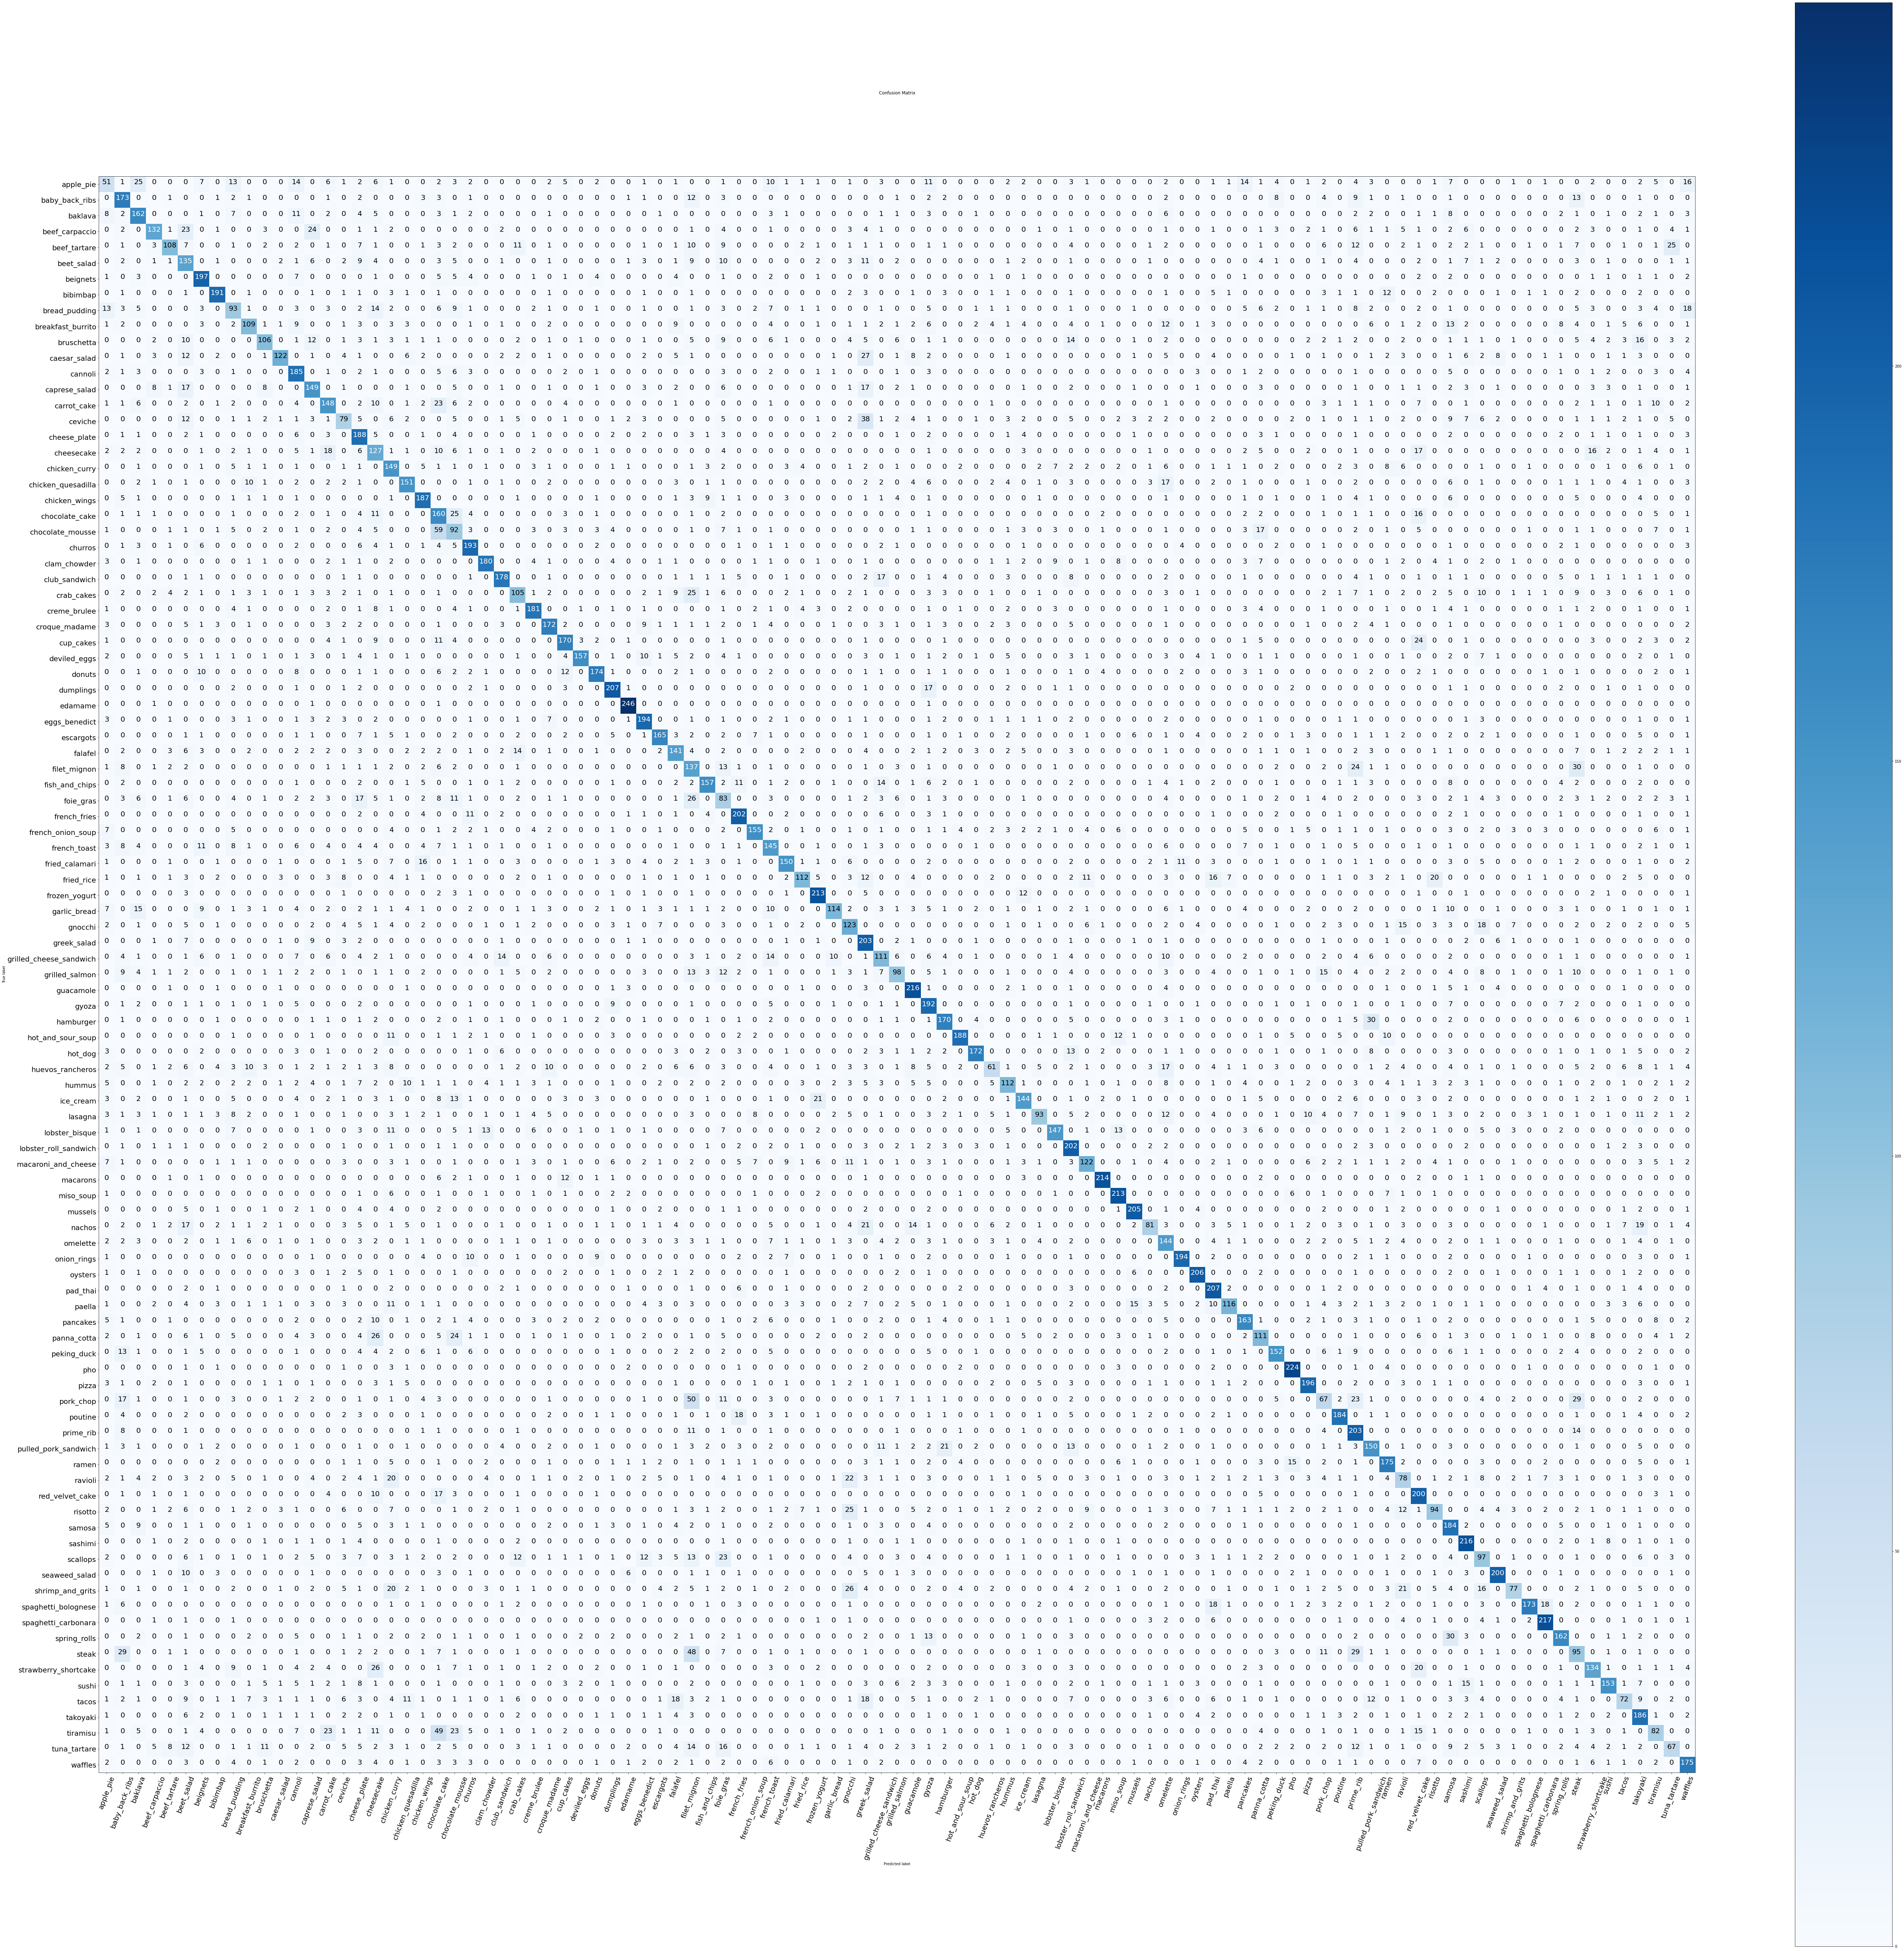

In [ ]:
make_confusion_matrix(y_true = y_labels,
                 y_pred = pred_classes,
                 classes = class_names,
                 figsize = (100,100),
                 text_size = 20,
                 savefig=True)

# Classification Report

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_true = y_labels,
                            y_pred = pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels,
                                                   pred_classes,
                                                   output_dict = True)

Showing F-1 Score of every class

In [ ]:
classification_report_dict['99']['f1-score']

0.35356200527704484

In [ ]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
    if k == 'accuracy': # stop once we get to accuracy key
        break
    else:
        # Add class names and f1-scores to new dictionary
        class_f1_scores[class_names[int(k)]] = v['f1-score']
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [ ]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({'class_names': list(class_f1_scores.keys()),
                         'f1-score': list(class_f1_scores.values())}).sort_values('f1-score', ascending = False)

In [ ]:
f1_scores

,class_names,f1-score
33,edamame,0.937143
63,macarons,0.895397
75,pho,0.866538
91,spaghetti_carbonara,0.847656
69,oysters,0.834008
...,...,...
56,huevos_rancheros,0.339833
22,chocolate_mousse,0.329159
77,pork_chop,0.308756
39,foie_gras,0.297491


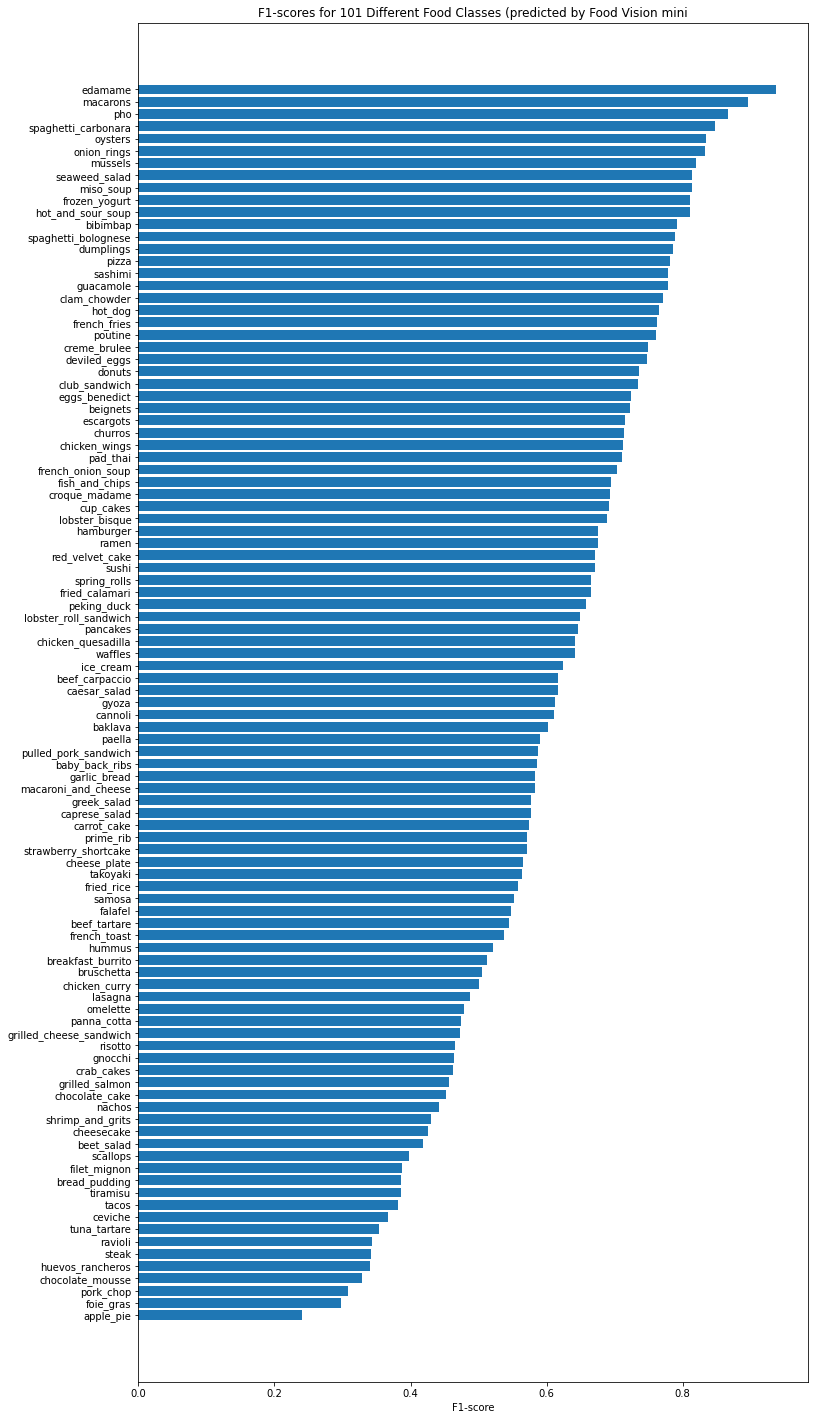

In [ ]:
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores['f1-score'].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores['class_names'])

ax.set_xlabel('F1-score')
ax.set_title('F1-scores for 101 Different Food Classes (predicted by Food Vision mini')
ax.invert_yaxis(); # reverse order of our plot

## Visualizing predictions on test images

In [ ]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale = True):
    """
    Reads in an image from filename, turns it into a tensor and reshapes into
    specified shape (img_shape, img_shape, color_channels = 3).

    Args:
        filename (str): path to target image
        image_shape (int): height/width dimension of target image size
        scale (bool): scale pixel values from 0-255 to 0-1 or not

    Returns:
        Image tensor of shape (img_shape, img_shape, 3)
    """
    # Read in the image
    img = tf.io.read_file(filename)

    # Decode image into tensor
    img = tf.io.decode_image(img, channels = 3)

    # Resize the image
    img = tf.image.resize(img, [img_shape, img_shape])

    # Scale? yes/no
    if scale:
        # rescale the image (get all values between 0 and 1)
        return img/255.
    else:
        return img # don't need to rescale images for EfficientNet models in TensorFlow

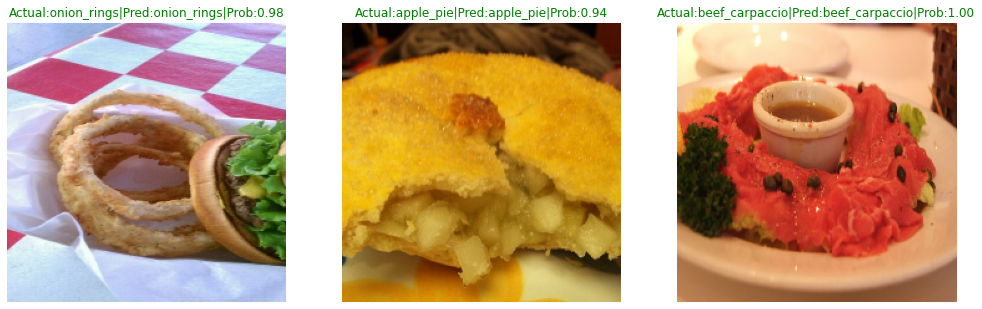

In [ ]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize = (17,10))
for i in range(3):
    # Choose a random image(s) from a random class(es)
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir('/content/101_food_classes_10_percent/test/' + '/' + class_name))
    filepath = '/content/101_food_classes_10_percent/test/' + class_name + '/' + filename

    # Load the image and make predictions
    img = load_and_prep_image(filepath, scale = False)
    pred_prob = model.predict(tf.expand_dims(img, axis = 0)) # get prediction probabilities array
    pred_class = class_names[pred_prob.argmax()] # get highest prediction probability index
    #print(pred_prob)
    #print(pred_class)

    # Plot the images
    plt.subplot(1, 3, i+1)
    plt.imshow(img/255)
    if class_name == pred_class: # if predicted class matches truth class, make text green
        title_color = 'g'
    else:
        title_color = 'r'
    plt.title(f'Actual:{class_name}|Pred:{pred_class}|Prob:{pred_prob.max():.2f}', c = title_color)
    plt.axis(False);

In [ ]:

img = load_and_prep_image(filepath, scale = False)
tf.expand_dims(img, axis = 0).shape

TensorShape([1, 224, 224, 3])

## Finding the most wrong predictions

In [ ]:
filepaths = []
for filepath in test_data.list_files('/content/101_food_classes_10_percent/test/*/*.jpg',
                                     shuffle = False):
    filepaths.append(filepath.numpy())
filepaths[-10:]

[b'/content/101_food_classes_10_percent/test/waffles/901565.jpg',
 b'/content/101_food_classes_10_percent/test/waffles/905007.jpg',
 b'/content/101_food_classes_10_percent/test/waffles/908565.jpg',
 b'/content/101_food_classes_10_percent/test/waffles/913086.jpg',
 b'/content/101_food_classes_10_percent/test/waffles/919275.jpg',
 b'/content/101_food_classes_10_percent/test/waffles/942009.jpg',
 b'/content/101_food_classes_10_percent/test/waffles/954028.jpg',
 b'/content/101_food_classes_10_percent/test/waffles/96181.jpg',
 b'/content/101_food_classes_10_percent/test/waffles/97015.jpg',
 b'/content/101_food_classes_10_percent/test/waffles/971843.jpg']

In [ ]:
# 2. Create a DataFrame of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({'img_path': filepaths,
                        'y_true': y_labels,
                        'y_pred': pred_classes,
                        'pred_comf': preds_probs.max(axis = 1), # get the max prediction probability values
                        'y_true_classname': [class_names[i] for i in y_labels],
                        'y_pred_classname': [class_names[i] for i in pred_classes]})

In [ ]:
pred_df

,img_path,y_true,y_pred,pred_comf,y_true_classname,y_pred_classname
0,b'/content/101_food_classes_10_percent/test/ap...,0,52,0.847419,apple_pie,gyoza
1,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.964017,apple_pie,apple_pie
2,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.959259,apple_pie,apple_pie
3,b'/content/101_food_classes_10_percent/test/ap...,0,80,0.658607,apple_pie,pulled_pork_sandwich
4,b'/content/101_food_classes_10_percent/test/ap...,0,79,0.367900,apple_pie,prime_rib
...,...,...,...,...,...,...
25245,b'/content/101_food_classes_10_percent/test/wa...,100,100,0.972823,waffles,waffles
25246,b'/content/101_food_classes_10_percent/test/wa...,100,16,0.878027,waffles,cheese_plate
25247,b'/content/101_food_classes_10_percent/test/wa...,100,100,0.537900,waffles,waffles
25248,b'/content/101_food_classes_10_percent/test/wa...,100,94,0.501950,waffles,strawberry_shortcake


In [ ]:
# 3. Find out in our DataFrame which predictions are wrong
pred_df['pred_correct'] = pred_df['y_true_classname'] == pred_df['y_pred_classname']
pred_df.head()

,img_path,y_true,y_pred,pred_comf,y_true_classname,y_pred_classname,pred_correct
0,b'/content/101_food_classes_10_percent/test/ap...,0,52,0.847419,apple_pie,gyoza,False
1,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.964017,apple_pie,apple_pie,True
2,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.959259,apple_pie,apple_pie,True
3,b'/content/101_food_classes_10_percent/test/ap...,0,80,0.658607,apple_pie,pulled_pork_sandwich,False
4,b'/content/101_food_classes_10_percent/test/ap...,0,79,0.367900,apple_pie,prime_rib,False


In [ ]:
# 4. Sort our DataFrame to have the most wrong predictions at the top
top_100_wrong = pred_df[pred_df['pred_correct'] == False].sort_values('pred_comf', ascending = False)[:100]
top_100_wrong.head(20)

,img_path,y_true,y_pred,pred_comf,y_true_classname,y_pred_classname,pred_correct
21810,b'/content/101_food_classes_10_percent/test/sc...,87,29,0.999997,scallops,cup_cakes,False
231,b'/content/101_food_classes_10_percent/test/ap...,0,100,0.999995,apple_pie,waffles,False
15359,b'/content/101_food_classes_10_percent/test/lo...,61,53,0.999988,lobster_roll_sandwich,hamburger,False
23539,b'/content/101_food_classes_10_percent/test/st...,94,83,0.999987,strawberry_shortcake,red_velvet_cake,False
21400,b'/content/101_food_classes_10_percent/test/sa...,85,92,0.999981,samosa,spring_rolls,False
24540,b'/content/101_food_classes_10_percent/test/ti...,98,83,0.999947,tiramisu,red_velvet_cake,False
2511,b'/content/101_food_classes_10_percent/test/br...,10,61,0.999945,bruschetta,lobster_roll_sandwich,False
5574,b'/content/101_food_classes_10_percent/test/ch...,22,21,0.999939,chocolate_mousse,chocolate_cake,False
17855,b'/content/101_food_classes_10_percent/test/pa...,71,65,0.999931,paella,mussels,False
23797,b'/content/101_food_classes_10_percent/test/su...,95,86,0.999904,sushi,sashimi,False


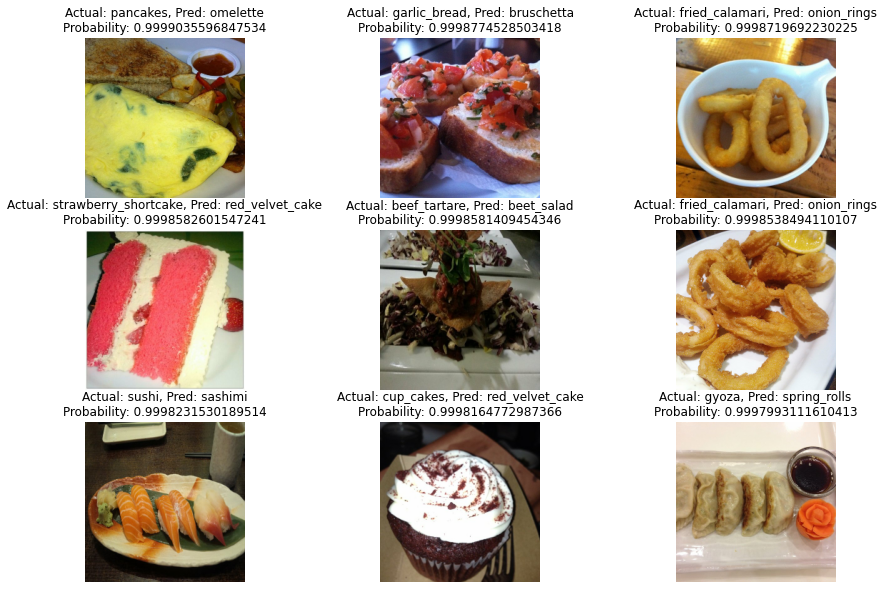

In [ ]:
# Visualize the test data samples which have the wrong predictions but highest pred probability
images_to_view = 9
start_index = 10
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
    plt.subplot(3, 3, i+1)
    img = load_and_prep_image(row[1], scale = False)
    _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # only interested in a few parameters of each row.
    plt.imshow(img/255.)
    plt.title(f'Actual: {y_true_classname}, Pred: {y_pred_classname}\nProbability: {pred_prob}');
    plt.axis(False)